<a href="https://colab.research.google.com/github/tzvikif/Bananas/blob/main/BananasTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and CONSTANS


In [4]:
#from google.colab import files
#uploaded = files.upload()


In [5]:
!pip install rasterio
!pip install albumentations==0.4.6
!pip install tifffile

     |████████████████████████████████| 19.1MB 1.3MB/s 
     |████████████████████████████████| 122kB 18.6MB/s 
     |████████████████████████████████| 952kB 31.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=ba78c9681d4d5bc5efb5fa3d750e0963994744606dc221926d54a4d991f8eb12
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
%cd '/content/gdrive/MyDrive/BananaTrees/Bananas'
from utils import mean_average_precision

/content/gdrive/MyDrive/BananaTrees/Bananas


##For checkpoints

In [8]:
# Imports
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision
import os
import cv2
import glob
from skimage import io
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment and creates mini batches
import xml.etree.ElementTree as et #for xml parsing
import rasterio as rs #reads geotiff files
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
from matplotlib import patches as patches

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from datetime import datetime
#sklearn
from sklearn.model_selection import KFold
from utils import subset_of_data

DIR_ANNOTATIONS = '/content/gdrive/MyDrive/data/PalmTrees/Training'
DIR_IMAGES = '/content/gdrive/MyDrive/data/PalmTrees/Training'
#DIR_TRAIN = f'{DIR_INPUT}/Training'
#DIR_TEST = f'{DIR_INPUT}/test'
LOAD_WEIGHTS = True
SAVE_WEIGHTS = False
SKIP_TRAINING = False
NUM_EPOCHS = 10
now = datetime.now()
current_time = now.strftime("%d%m_%H%M")
#WEIGHTS_FILENAME = f'my_checkpoint{current_time}.pth.tar'
file_id = ''
WEIGHTS_FILENAME = f'/content/gdrive/MyDrive/BananaTrees/weights/my_checkpoint.pth.tar'
INIT_WEIGHTS_FILENAME = '/content/gdrive/MyDrive/BananaTrees/weights/init_checkpoint.pth.tar'

In [9]:
def save_checkpoint(state, filename=WEIGHTS_FILENAME):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def file_weights_name(file_id=''):
  pref = WEIGHTS_FILENAME[:-8]
  suffix = WEIGHTS_FILENAME[-8:]
  return pref + str(file_id) + suffix
  return WEIGHTS_FILENAME
'''
def main():
    # Initialize network
    model = torchvision.models.vgg16(pretrained=False)
    optimizer = optim.Adam(model.parameters())

    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    # Try save checkpoint
    save_checkpoint(checkpoint)

    # Try load checkpoint
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)
    '''


'\ndef main():\n    # Initialize network\n    model = torchvision.models.vgg16(pretrained=False)\n    optimizer = optim.Adam(model.parameters())\n\n    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}\n    # Try save checkpoint\n    save_checkpoint(checkpoint)\n\n    # Try load checkpoint\n    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)\n    '

##Create train/validation set

In [10]:
def train_validation(names,train_frac=0.8):
  train_names = names[:int(len(names)*train_frac)]
  valid_names = names[int(len(names)*train_frac):]
  return train_names,valid_names
names = subset_of_data(DIR_ANNOTATIONS)
train_files,valid_files = train_validation(names)


At first stage using *palm trees* datasets

In [11]:
class PalmTreesDataset(Dataset):
    def __init__(self,root_dir,filenames,transforms=None):
        self.root_dir = root_dir
        self.annotations = filenames
        self.transforms = transforms
        self.SCHEME = '{http://tempuri.org/XMLSchema.xsd}'

    def __len__(self):
        #print(f'len:{len(self.annotations)}')
        return len(self.annotations)

    def __getitem__(self,index):
        annotated_path = self.annotations[index]
        img_name,bboxes = self.get_annotatated_data(annotated_path)
        #print(f'** index:{index}, img_name:{img_name}')
        img_path = os.path.join(self.root_dir,img_name)
        #print(f'image_path:{img_path}')
        try:
          with rs.open(img_path) as img:
              image = img.read()
        except FileNotFoundError as error:
          print(f'no such file:{img_path}\nerror message:{error}')
          #raise Exception('ooops')
        shape = image.shape
        image = np.transpose(image,(1,2,0))
        #print(f'**shape:{image.shape}')
        image = image/255
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((bboxes.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            #print(f'image.shape:{image.shape:}, bboxes:{target["boxes"]}')
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            #print(f'** shape:{image.shape}')
            sample = self.transforms(**sample)
            #print(f'** after transform **:{sample["bboxes"]}')
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, img_name

    def get_annotatated_data(self,annotated_path):
      try:
        xtree = et.parse(annotated_path)
      except:
        print(f'no such file:{annotated_path}')
        raise Exception('ooops')
      xroot = xtree.getroot()
      filename_element = xroot.find(self.SCHEME+'filename')
      img_name = filename_element.text
      for element in xroot.find('./'+self.SCHEME+'size'):
          if element.tag == self.SCHEME + 'width':
              width = element.text
          if element.tag == self.SCHEME + 'height':
              height = element.text
      rows = len(xroot.findall('.//'+self.SCHEME+'bndbox'))
      bboxes = np.zeros([rows,4])
      for i,bbox in enumerate(xroot.findall('.//'+self.SCHEME+'bndbox')):
          xmin = int(bbox.find(self.SCHEME+'xmin').text)
          ymin = int(bbox.find(self.SCHEME+'ymin').text)
          xmax = int(bbox.find(self.SCHEME+'xmax').text)
          ymax = int(bbox.find(self.SCHEME+'ymax').text)
          bboxes[i,:] = xmin,ymin,xmax,ymax
      return img_name,bboxes


In [12]:
#train_dataset = PalmTreesDataset(DIR_IMAGES,train_files)
#image,target,image_id = train_dataset[0]


In [13]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_train_transform_tensor():
    return A.Compose([
        ToTensorV2(p=1.0)
    ],)
def get_train_transform_tensor():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


## **Create the model**

In [14]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [15]:
num_classes = 2  # 1 class (Palm) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
#model

In [17]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))
def create_loaders(train_files,valid_files):
  train_dataset = PalmTreesDataset(DIR_IMAGES, train_files, get_train_transform())
  valid_dataset = PalmTreesDataset(DIR_IMAGES, valid_files, get_valid_transform())
  # split the dataset in train and test set
  indices = torch.randperm(len(train_dataset)).tolist()

  train_data_loader = DataLoader(
      train_dataset,
      batch_size=4,
      shuffle=True,
      num_workers=2,
      collate_fn=collate_fn
  )

  valid_data_loader = DataLoader(
      valid_dataset,
      batch_size=4,
      shuffle=False,
      num_workers=2,
      collate_fn=collate_fn
  )
  return (train_data_loader,valid_data_loader)


In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##Sample

In [20]:
train_dataset = PalmTreesDataset(DIR_IMAGES, train_files, get_train_transform())
train_data_loader = DataLoader(
      train_dataset,
      batch_size=4,
      shuffle=True,
      num_workers=2,
      collate_fn=collate_fn
  )
images, targets, image_ids = next(iter(train_data_loader))
#print(f'images:{images[0].shape} targets:{targets[0].keys()} image_ids:{image_ids[0]}')
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [21]:
boxes = targets[3]['boxes'].cpu().numpy().astype(np.int32)
sample = images[3].permute(1,2,0).cpu().numpy()
print(sample.shape)

(501, 445, 3)


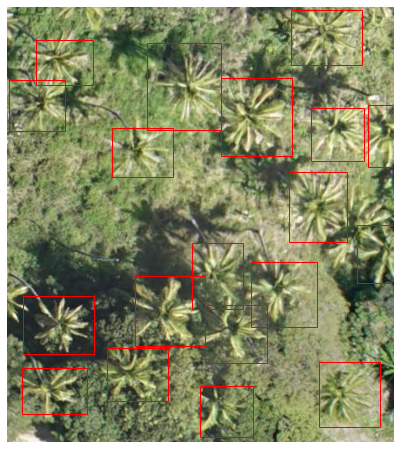

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='r', facecolor="none")
    ax.add_patch(rect)    
ax.set_axis_off()
ax.imshow(sample)

##Train

In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None
if LOAD_WEIGHTS == True:
  load_checkpoint(WEIGHTS_FILENAME, model, optimizer)



=> Loading checkpoint


In [24]:
def train(train_data_loader):
  losses_list = []
  model.train()
  loss_hist = Averager()
  itr = 1
  for epoch in range(NUM_EPOCHS):
      loss_hist.reset()
      
      for images, targets, image_ids in train_data_loader:
          images = list(image.to(device,dtype=torch.float) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)
          #print(f'loss_dict:{loss_dict}')
          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()

          loss_hist.send(loss_value)

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          if itr % 50 == 0:
              print(f"Iteration #{itr} loss: {loss_value}")

          itr += 1
      
      # update the learning rate
      if lr_scheduler is not None:
          lr_scheduler.step()
      print(f"Epoch #{epoch} loss: {loss_hist.value}")
      losses_list.append(loss_value)
  return losses_list
#if not SKIP_TRAINING:
#  train(train_data_loader)
#if SAVE_WEIGHTS:
#  checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
#  save_checkpoint(checkpoint)  

In [25]:
def loss_plot(losses):
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.set_title('Losses')
  ax.plot(losses)
  #ax.legend(loc='upper left')
  ax.set_ylabel('Average Loss')
  ax.set_xlabel('#Epochs')

#loss_plot(losses_list)

##Validation

In [26]:
#filenames = ['palm_tile7_1.xml','palm_tile7_3.xml']
#filenames = ['palm_tile4_12.xml']
#valid_files = [os.path.join(DIR_ANNOTATIONS,fn) for fn in filenames]
valid_dataset = PalmTreesDataset(DIR_IMAGES, valid_files, get_valid_transform())
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)


In [27]:
images, targets, image_ids = next(iter(valid_data_loader))

In [28]:
images = list(img.to(device,dtype=torch.float) for img in images)

In [29]:
model.eval()
cpu_device = torch.device("cpu")
#dict_keys(['boxes', 'labels', 'scores'])
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes = outputs[0]['boxes']
samples = [image.permute(1,2,0).cpu().numpy() for image in images] 

In [30]:
#def display_samples(images,outputs,image_ids=[None]*len(images)):
def display_samples(images,targets,image_ids):
  
  cpu_device = torch.device("cpu")
  images = list(img.to(device,dtype=torch.float) for img in images)
  model.eval()
  outputs = model(images)
  print('after eval')
  outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
  samples = [image.permute(1,2,0).cpu().numpy() for image in images]
  fig, ax = plt.subplots(2, 2, figsize=(16, 16))
  for i,(sample,image_id) in enumerate(zip(samples,image_ids)):
    ax[i%2,i//2].set_axis_off()
    boxes = outputs[i]['boxes']
    for box in boxes:
      rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='r', facecolor="none")
      ax[i%2,i//2].add_patch(rect)    
      
    boxes = targets[i]['boxes']
    num_boxes=len(boxes)
    for box in boxes:
      rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='b', facecolor="none")
      ax[i%2,i//2].add_patch(rect)  
    if image_id!=None:
      ax[i%2,i//2].set_title(image_id[:-4]+' '+str(num_boxes))  
    ax[i%2,i//2].imshow(sample)


after eval


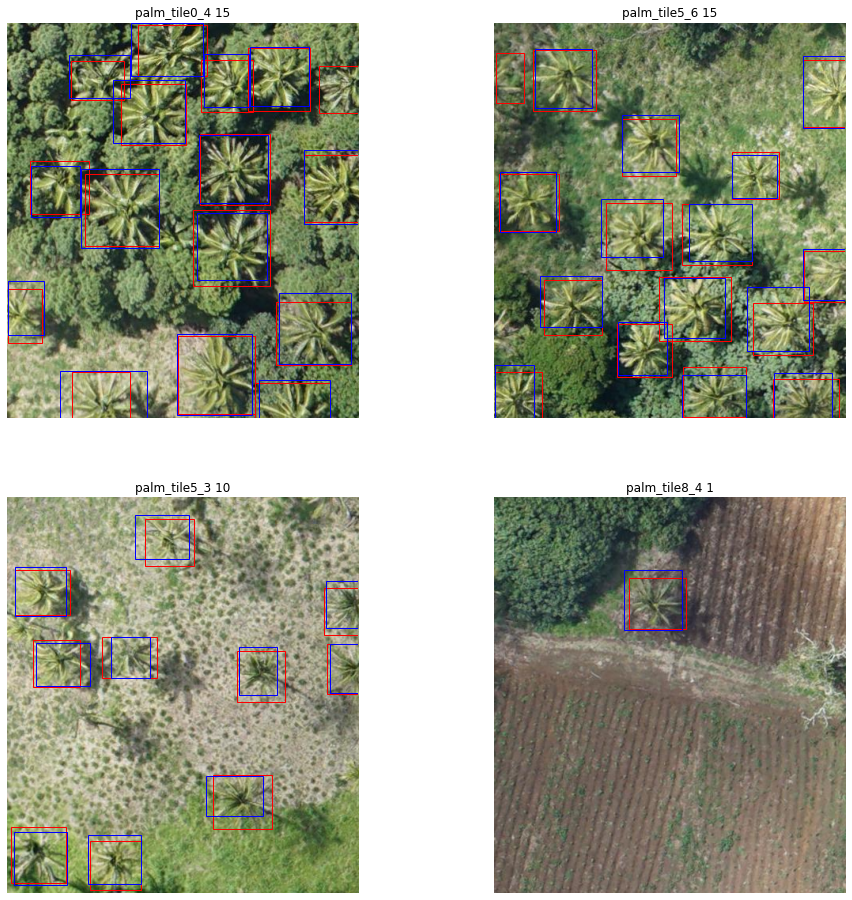

In [31]:
images, targets, image_ids = next(iter(valid_data_loader))
display_samples(images, targets, image_ids)

#Metric Calculation
###Mean Average Precision




In [32]:
model.eval()
cpu_device = torch.device("cpu")
#dict_keys(['boxes', 'labels', 'scores'])
#outputs = model(images)
#move the key/value to cpu
#outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
def prepare_for_mAP(valid_data_loader):
  '''
  :input data loader
  :return (pred_boxes,true_boxes)
  '''
  pred_boxes = []
  true_boxes = []
  with torch.no_grad():
    for i,(images, targets, image_ids) in enumerate(valid_data_loader):
      images = list(img.to(device,dtype=torch.float) for img in images)
      outputs = model(images)
      outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
      for idx,image_pred in enumerate(outputs): #for each image
        boxes = image_pred['boxes']
        labels = image_pred['labels']
        scores = image_pred['scores']
        for i,box in enumerate(boxes): #for each bbox
          pred_boxes.append([image_ids[idx],labels[i]-1,scores[i],box[0],box[1],box[2],box[3]])

      for idx,gt in enumerate(targets):
        boxes = gt['boxes']
        labels = gt['labels']
        for i,box in enumerate(boxes):
          true_boxes.append([image_ids[idx],labels[i]-1,1.0,box[0],box[1],box[2],box[3]])
  return (pred_boxes,true_boxes)
  



In [33]:
#format for pred_boxes,true_boxes [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
pred_boxes,target_boxes = prepare_for_mAP(valid_data_loader)
print(len(pred_boxes))
print(len(target_boxes))

#print(f'pred_boxes:{pred_boxes[0,3:6]} true_boxes:{true_boxes[0,3:6]}')
#mean_average_precision(pred_boxes=pred_boxes,true_boxes=true_boxes,iou_threshold=0.5,box_format='corners',num_classes=1)

230
216


In [34]:
def evaluate_model(valid_data_loader,threshold=0.5):
  model.eval()
  cpu_device = torch.device("cpu")
  samples = [image.permute(1,2,0).cpu().numpy() for image in images]
  pred_boxes,true_boxes = prepare_for_mAP(valid_data_loader)
  mAP = mean_average_precision(pred_boxes=pred_boxes,true_boxes=true_boxes,iou_threshold=threshold,box_format='corners',num_classes=1)
  return mAP

In [44]:
thresholds = np.arange(start=0.3, stop=0.7, step=0.05)
mAP_sum = 0
for threshold in thresholds:
  current_mAP = evaluate_model(valid_data_loader,threshold)
  mAP_sum += current_mAP
mAP = mAP_sum/len(thresholds)
print(f'mAP:{mAP:.2f}')

mAP:0.89


#k-Fold

In [32]:
'''
k = 5
kf = KFold(n_splits=k)
mAPs = []
max_mAP = 0
names = glob.glob(f'{DIR_ANNOTATIONS}/palm*.xml')
for train_index, valid_index in kf.split(names):
    train_names = [names[i] for i in train_index]


    valid_names = [names[i] for i in valid_index]
    train_data_loader,valid_data_loader = create_loaders(train_names,valid_names)
    load_checkpoint(INIT_WEIGHTS_FILENAME, model, optimizer)
    losses = train(train_data_loader)
    pred_boxes,true_boxes = prepare_for_mAP(valid_data_loader)
    current_mAP = mean_average_precision(pred_boxes=pred_boxes,true_boxes=true_boxes,iou_threshold=0.5,box_format='corners',num_classes=1)
    if current_mAP > max_mAP:
      if SAVE_WEIGHTS:
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)  
'''

'\nk = 5\nkf = KFold(n_splits=k)\nmAPs = []\nmax_mAP = 0\nnames = glob.glob(f\'{DIR_ANNOTATIONS}/palm*.xml\')\nfor train_index, valid_index in kf.split(names):\n    train_names = [names[i] for i in train_index]\n\n\n    valid_names = [names[i] for i in valid_index]\n    train_data_loader,valid_data_loader = create_loaders(train_names,valid_names)\n    load_checkpoint(INIT_WEIGHTS_FILENAME, model, optimizer)\n    losses = train(train_data_loader)\n    pred_boxes,true_boxes = prepare_for_mAP(valid_data_loader)\n    current_mAP = mean_average_precision(pred_boxes=pred_boxes,true_boxes=true_boxes,iou_threshold=0.5,box_format=\'corners\',num_classes=1)\n    if current_mAP > max_mAP:\n      if SAVE_WEIGHTS:\n        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}\n        save_checkpoint(checkpoint)  \n'

#Train on subset of the dataset
10%,20%,30%

In [33]:
'''
fractions = [0.2,0.3,0.4,0.5]
for f in fractions:
  names = subset_of_data(DIR_ANNOTATIONS,fraction=f)
  print(f'names:{len(names)}')
  train_files,valid_files = train_validation(names,train_frac=0.8)
  print(f'train_files:{len(train_files)} valid_files:{len(valid_files)}')
  train_data_loader,valid_data_loader = create_loaders(train_files,valid_files)
  load_checkpoint(INIT_WEIGHTS_FILENAME, model, optimizer)
  losses = train(train_data_loader)
  current_mAP = evaluate_model(valid_data_loader)
  print(f'current_mAP:{current_mAP}')
  checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
  save_checkpoint(checkpoint,filename=file_weights_name(f))  
  display_samples(valid_data_loader)
'''


'\nfractions = [0.2,0.3,0.4,0.5]\nfor f in fractions:\n  names = subset_of_data(DIR_ANNOTATIONS,fraction=f)\n  print(f\'names:{len(names)}\')\n  train_files,valid_files = train_validation(names,train_frac=0.8)\n  print(f\'train_files:{len(train_files)} valid_files:{len(valid_files)}\')\n  train_data_loader,valid_data_loader = create_loaders(train_files,valid_files)\n  load_checkpoint(INIT_WEIGHTS_FILENAME, model, optimizer)\n  losses = train(train_data_loader)\n  current_mAP = evaluate_model(valid_data_loader)\n  print(f\'current_mAP:{current_mAP}\')\n  checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}\n  save_checkpoint(checkpoint,filename=file_weights_name(f))  \n  display_samples(valid_data_loader)\n'

#Evaluate Banana trees

In [34]:
import tifffile as tif
from PIL import Image
bananas_path = '/content/gdrive/MyDrive/BananaTrees/data'
banana_files = ['tile_4_2.tif','tile_4_3.tif','tile_4_4.tif','tile_4_5.tif']
images = []
for file in banana_files:
  img = tif.imread(os.path.join(bananas_path, file))
  m = np.max(img)
  img = img * (1/m)
  #np_img = np.array(img)/255
  images.append(img)
images = list(torch.tensor(img) for img in images)  
images = list(img.to(device,dtype=torch.float) for img in images)
images = [image.permute(2,0,1) for image in images]
model.eval()
cpu_device = torch.device("cpu")
#dict_keys(['boxes', 'labels', 'scores'])
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes = outputs[0]['boxes']
samples = [image.permute(1,2,0).cpu().numpy() for image in images] 

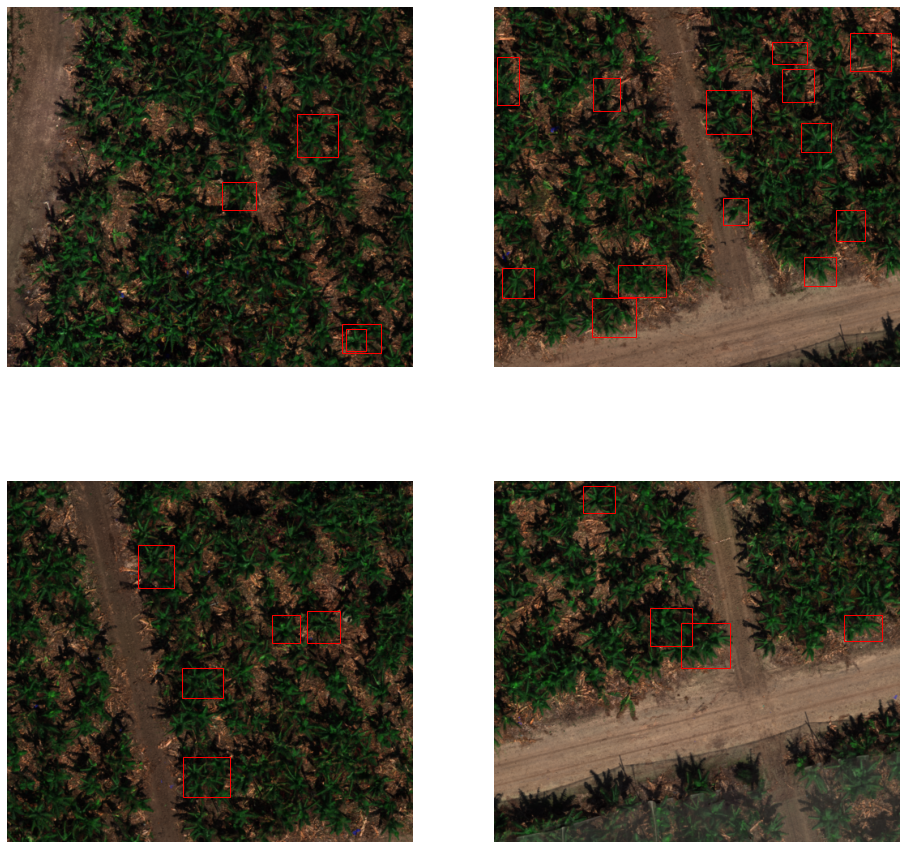

In [35]:
#display banana trees
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
boxes = outputs[0]['boxes']
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
for i,(sample,image_id) in enumerate(zip(samples,image_ids)):
  ax[i%2,i//2].set_axis_off()
  boxes = outputs[i]['boxes']
  for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1], edgecolor='r', facecolor="none")
    ax[i%2,i//2].add_patch(rect)    
  ax[i%2,i//2].imshow(sample)